# Evaluator Platypus Converter
This notebook covers how to use the Platypus conveter for Energyhub or EnergyPlus evaluators.

In [1]:
import numpy as np
import pandas as pd
from platypus import NSGAII, DTLZ2
import platypus
import random


from besos.evaluator import EvaluatorEP, EvaluatorEH
from besos import eppy_funcs as ef
from besos import pyehub_funcs as pf
from besos.parameters import FieldSelector, Parameter, ParameterEH, expand_plist, RangeParameter, CategoryParameter
from besos.problem import EPProblem, Problem, EHProblem
from besos import sampling
from besos import optimizer

# Base Platypus Example
Here is a simple example of generating a simple Platypus problem from the DTLZ2 function to be solved with the NSGAII algorithm. There are other algorithms outlined: https://platypus.readthedocs.io/en/latest/experimenter.html#comparing-algorithms-visually.

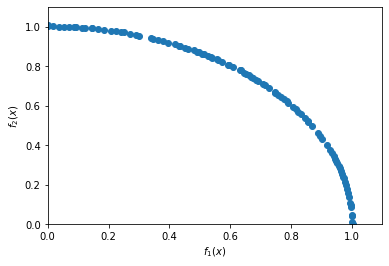

In [2]:
test = DTLZ2()# instantiate the optimization algorithm
algorithm = NSGAII(test)# optimize the problem using 10,000 function evaluations
algorithm.run(10000)# plot the results using matplotlib
import matplotlib.pyplot as plt
plt.scatter([s.objectives[0]for s in algorithm.result],
    [s.objectives[1]for s in algorithm.result])
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])
plt.xlabel("$f_1(x)$")
plt.ylabel("$f_2(x)$")
plt.show()

## Creating an Energyhub Evaluator to convert
The Platypus converter for Evaluators works with Energyhub Evaluators so long as each parameter also has a RangeParameter value_descriptor. 

In [3]:
hub = pf.get_hub() # load the hub model specified in config.yaml
EHparameters = [ParameterEH(['LINEAR_CAPITAL_COSTS','Boiler'], value_descriptor = RangeParameter(100.0,200.0), name = 'Boiler'),
              ParameterEH(['LINEAR_CAPITAL_COSTS','CHP'], value_descriptor = RangeParameter(300.0,400.0), name = 'CHP')]
objectives = ['total_cost','total_carbon'] # the objectives are the total_carbon and total_cost variables of the Energy Hub problem
EHproblem = EHProblem(EHparameters,objectives) # we make a problem out of the parameters and objectives
evaluatorEH = EvaluatorEH(EHproblem, hub) # and an Evaluator by combining with the hub model

In [4]:
EHproblem

EHProblem(inputs=[ParameterEH(name='Boiler', parameter_path=['LINEAR_CAPITAL_COSTS', 'Boiler'], value_descriptor=RangeParameter(min=100.0, max=200.0)), ParameterEH(name='CHP', parameter_path=['LINEAR_CAPITAL_COSTS', 'CHP'], value_descriptor=RangeParameter(min=300.0, max=400.0))], outputs=[Objective(name='total_cost'), Objective(name='total_carbon')], minimize_outputs=[True, True], converters={'outputs': <class 'IO_Objects.Objective'>, 'constraints': <class 'IO_Objects.Objective'>})

#### Converting Evaluator to Platypus problem
There's a converter in the evaluator module that makes the evaluator the function of a platypus problem with problem details from the evaluator's problem which are converted in the problem module.

In [5]:
platypus_problem= evaluatorEH.to_platypus()
EHalgorithm = NSGAII(platypus_problem)

In [6]:
EHalgorithm.run(5)
results1 = optimizer.solutions_to_df(EHalgorithm.result, EHproblem, parts=['inputs', 'outputs'])
results1

,Boiler,CHP,total_cost,total_carbon,pareto-optimal
0,125.606210,301.504401,983.593,53.2299,False
1,106.733175,319.666114,962.291,53.2299,False
2,137.279560,358.507858,1031.540,53.2299,False
3,106.739096,355.120714,980.365,53.2299,False
4,115.641162,393.643231,1014.400,53.2299,False
...,...,...,...,...,...
95,184.724335,354.375280,1106.240,53.2299,False
96,187.868157,320.898741,1094.280,53.2299,False
97,187.667927,339.393173,1103.380,53.2299,False
98,176.424691,305.923068,1068.120,53.2299,False


In [7]:
best = results1.loc[results1['pareto-optimal']==True]
best

,Boiler,CHP,total_cost,total_carbon,pareto-optimal
82,102.425807,300.770561,945.69,53.2299,True


## Creating an Energyplus Evaluator to convert

Just like the Energyhub Evaluator the Energyplus requires the parameters all have RangeParameters but this is easier with the expand_plist
that works with EnergyPlus Parameters.

It appears to require that the idf be the idf and not json. (Format returned in default get_idf() and not get_building().

In [8]:
parameters = expand_plist(
    {'NonRes Fixed Assembly Window':
    {'UFactor':(0.1,5),
    'Solar Heat Gain Coefficient':(0.01,0.99)
    },
    'Mass NonRes Wall Insulation':{'Thickness':(0.01,0.09)},
    })
objectives = ['Electricity:Facility', 'Gas:Facility']
problem = EPProblem(parameters, objectives)
idf = ef.get_idf()
evaluator = EvaluatorEP(problem, idf)

random.seed(1)
#run the first algorithm
platypus_problem = evaluator.to_platypus()
algorithm = platypus.NSGAII(problem=platypus_problem, population_size=5)
algorithm.run(5)

#run the second algorithm
generator = platypus.InjectedPopulation(algorithm.population)
alg2 = platypus.EpsMOEA(problem=platypus_problem, generator=generator, epsilons=3, population_size=5)
alg2.run(5)

results = optimizer.solutions_to_df(alg2.result, problem, parts=['inputs', 'outputs'])

value = results.iloc[0]['Electricity:Facility']
results

,UFactor,Solar Heat Gain Coefficient,Thickness,Electricity:Facility,Gas:Facility,pareto-optimal
0,3.835172,0.012064,0.045631,1.747893e+09,2.754759e+09,True
1,0.758385,0.840485,0.071102,2.034865e+09,2.024844e+09,True
2,3.635546,0.234187,0.085622,1.805304e+09,2.511114e+09,True
3,1.186289,0.439130,0.049665,1.872742e+09,2.282321e+09,True


In [9]:
results2 = optimizer.solutions_to_df(algorithm.result, problem, parts=['inputs', 'outputs'])
results2

,UFactor,Solar Heat Gain Coefficient,Thickness,Electricity:Facility,Gas:Facility,pareto-optimal
0,0.758385,0.840485,0.071102,2.034865e+09,2.024844e+09,True
1,1.349838,0.495526,0.045959,1.890486e+09,2.334315e+09,True
2,3.292806,0.782949,0.017509,2.027893e+09,2.977138e+09,False
3,0.238903,0.829050,0.044621,2.039309e+09,2.079423e+09,False
4,3.835172,0.012064,0.045631,1.747893e+09,2.754759e+09,True
